In [1]:
import torch, torchvision

In [2]:
from PIL import Image
# wget line useful in Google Colab
# ! wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/03_advanced_neural_networks/ALCF-Staff.jpg
alcf_image = Image.open("ALCF-Staff.jpg")

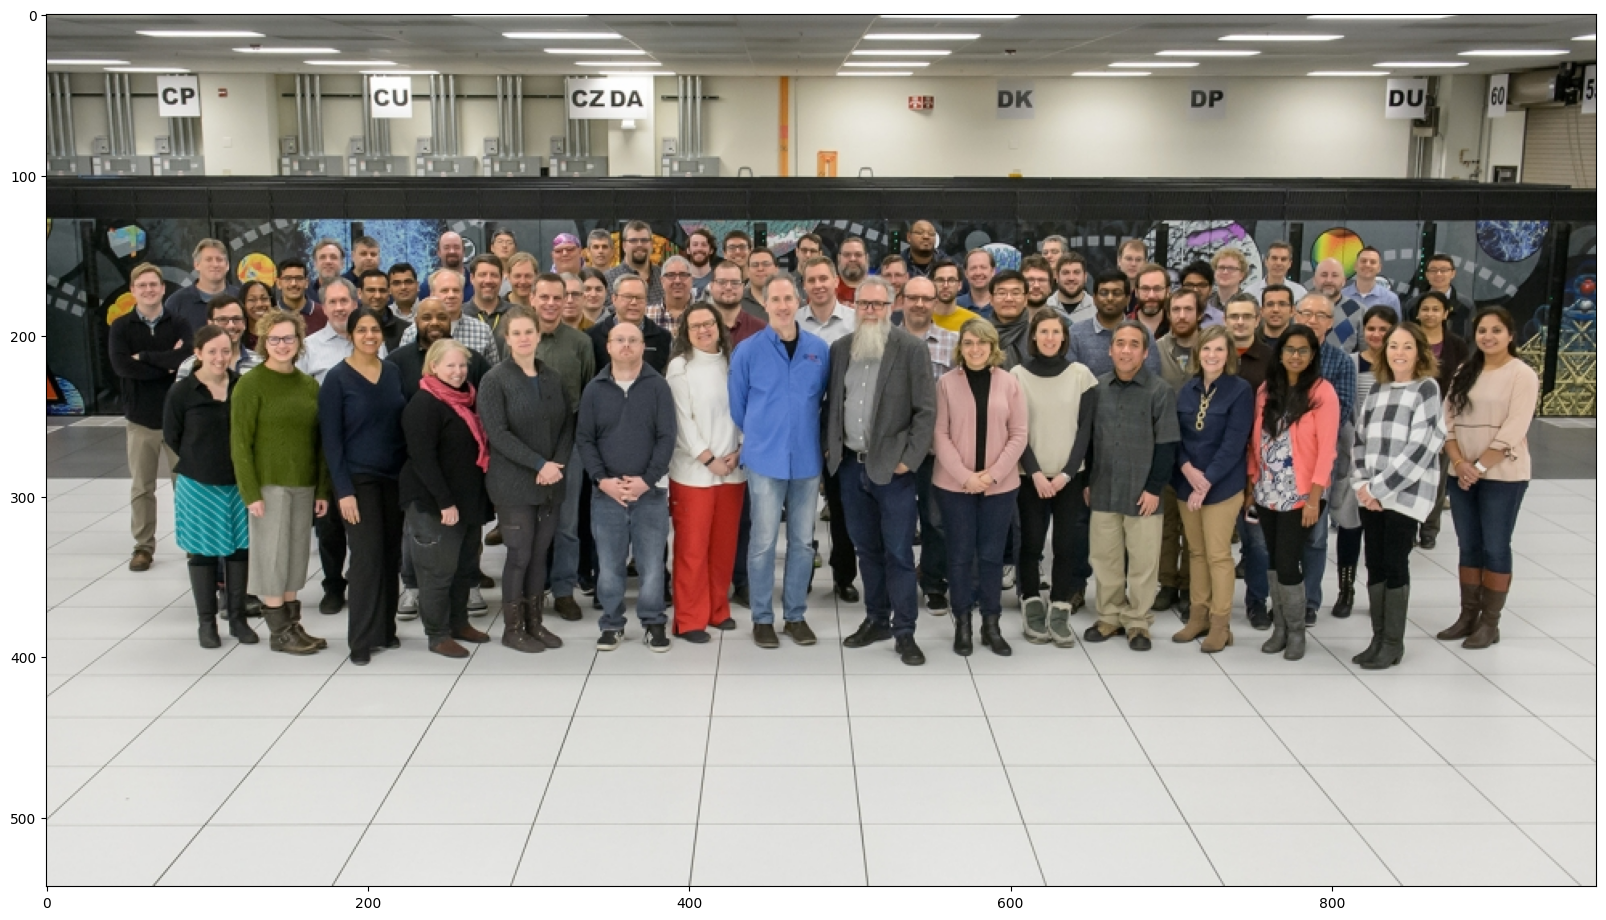

In [3]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


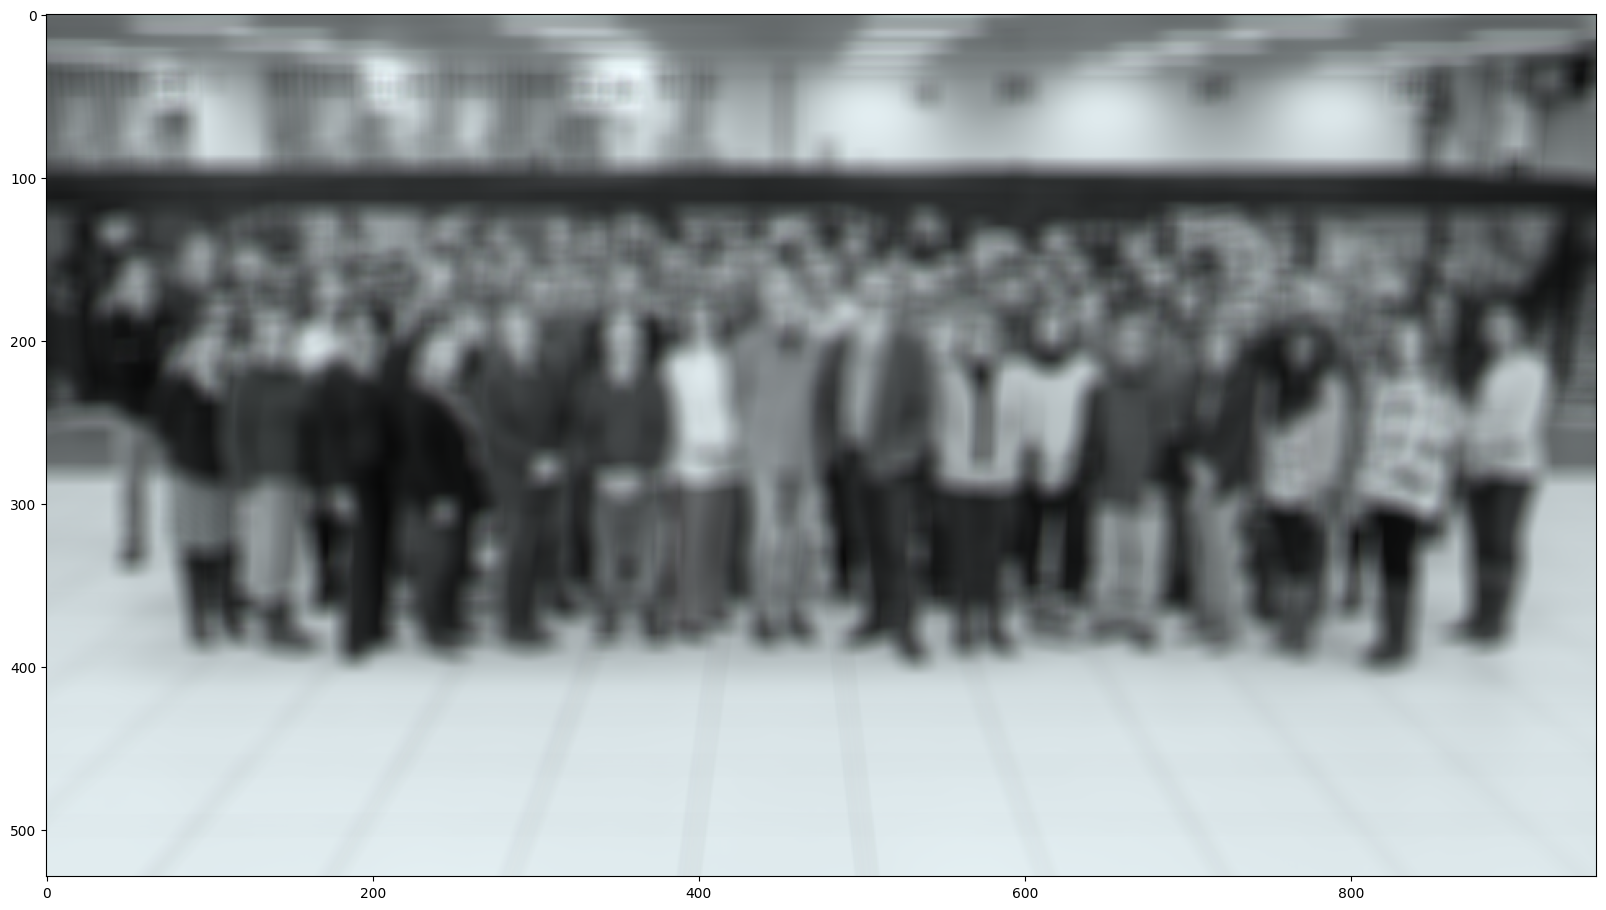

In [4]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

torch.Size([1, 3, 543, 965])


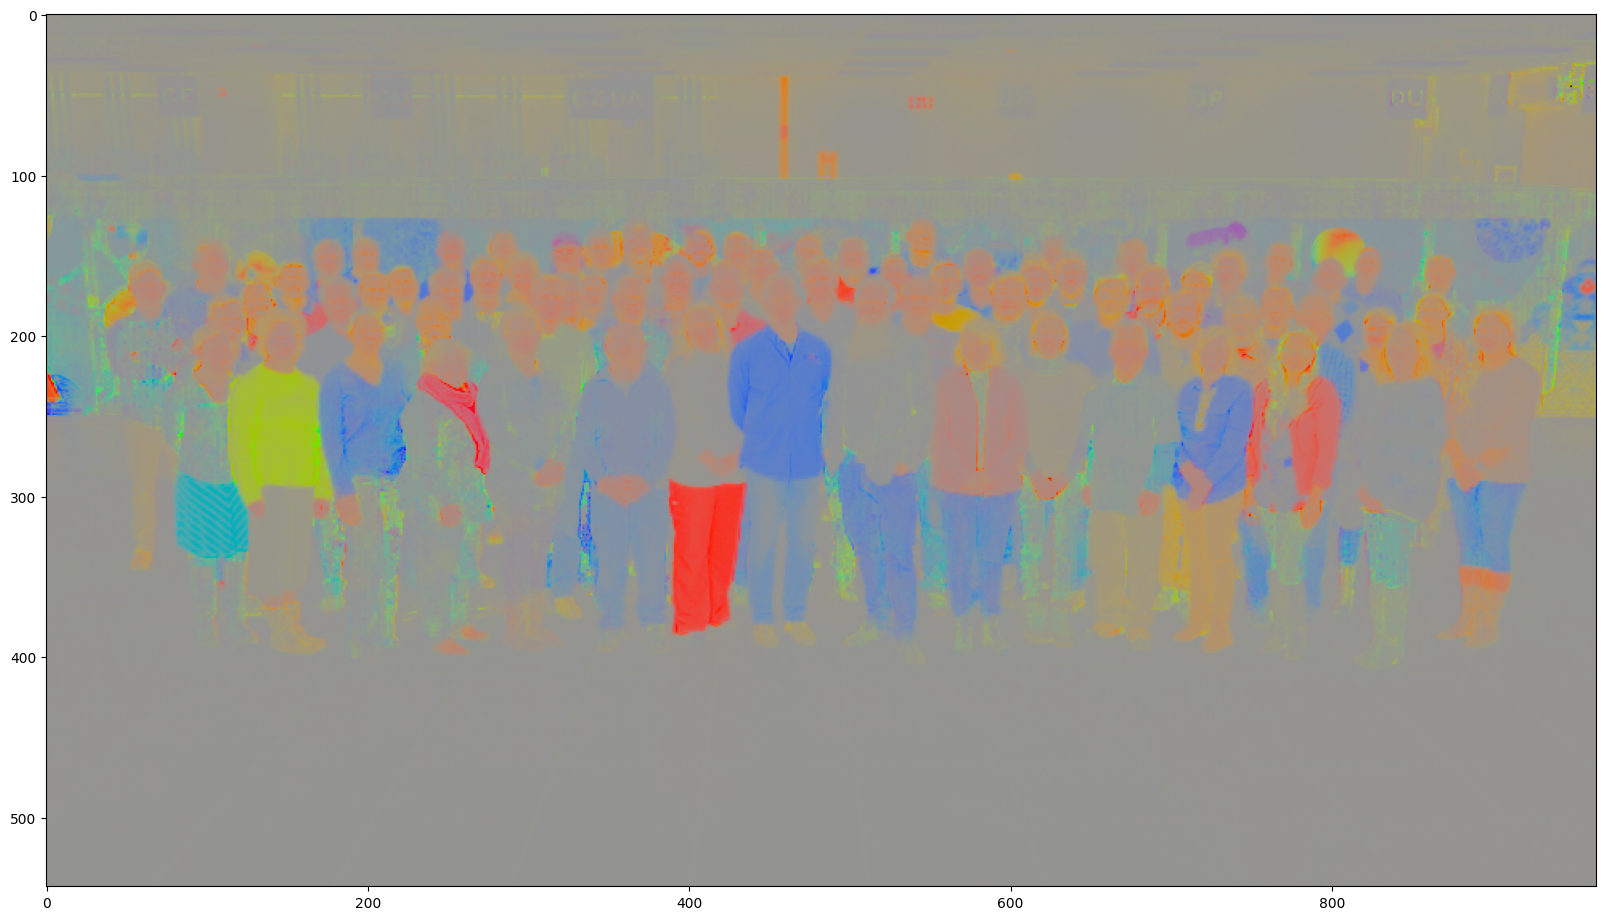

In [5]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

torch.Size([1, 3, 543, 965])


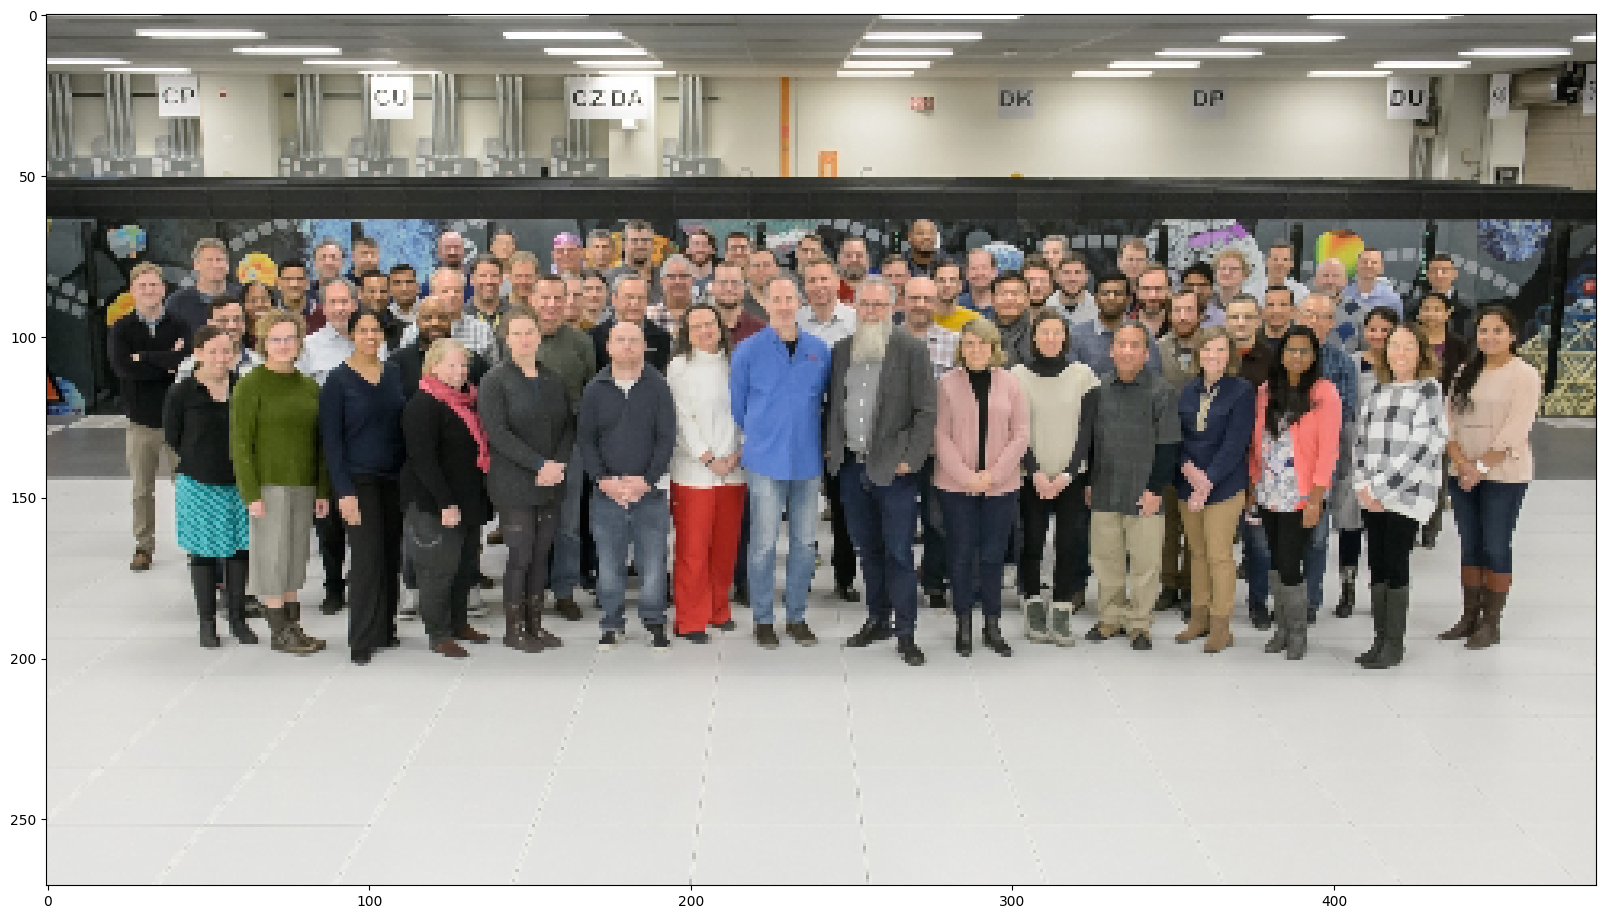

In [6]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

In [7]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=2)

/home/connormluttrell/.local/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

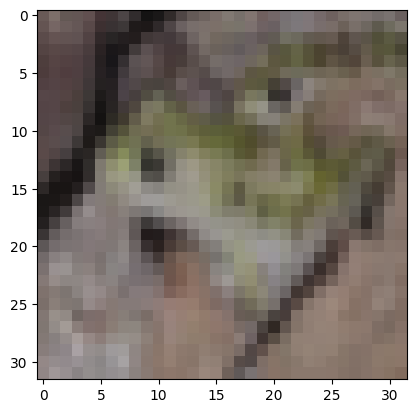

In [9]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [11]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [12]:
!pip install torchinfo # if not on Polaris

Defaulting to user installation because normal site-packages is not writeable


In [13]:
model = Classifier(32, 4, 2).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [14]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [15]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

In [17]:
from tqdm.notebook import tqdm

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.125, accuracy: 21.768


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.133, accuracy: 21.054


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.020, accuracy: 23.497


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 2.100, accuracy: 23.398


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.886, accuracy: 31.082


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.880, accuracy: 31.448


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.812, accuracy: 35.356


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.817, accuracy: 34.711


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.804, accuracy: 35.512


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.841, accuracy: 34.207


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.684, accuracy: 38.904


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.673, accuracy: 38.608


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.643, accuracy: 41.022


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.634, accuracy: 41.426


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.618, accuracy: 41.782


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.641, accuracy: 40.487


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.587, accuracy: 42.405


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.562, accuracy: 42.702


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.545, accuracy: 44.634


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Homework, Part 1

# Trial 1

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: train loss: 1.535, acc: 45.320 | val loss: 1.539, acc: 44.818


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: train loss: 1.521, acc: 44.579 | val loss: 1.512, acc: 44.670


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: train loss: 1.483, acc: 46.803 | val loss: 1.487, acc: 46.054


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: train loss: 1.527, acc: 45.188 | val loss: 1.545, acc: 44.343


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: train loss: 1.517, acc: 45.485 | val loss: 1.524, acc: 44.511


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: train loss: 1.511, acc: 44.781 | val loss: 1.524, acc: 43.612


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: train loss: 1.460, acc: 47.674 | val loss: 1.461, acc: 46.875


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: train loss: 1.436, acc: 48.794 | val loss: 1.444, acc: 47.597


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: train loss: 1.475, acc: 45.732 | val loss: 1.479, acc: 45.431


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: train loss: 1.477, acc: 46.156 | val loss: 1.480, acc: 45.085


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: train loss: 1.403, acc: 50.010 | val loss: 1.405, acc: 49.674


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: train loss: 1.426, acc: 49.286 | val loss: 1.435, acc: 48.734


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: train loss: 1.410, acc: 49.047 | val loss: 1.420, acc: 47.844


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: train loss: 1.383, acc: 50.899 | val loss: 1.394, acc: 49.842


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: train loss: 1.401, acc: 50.085 | val loss: 1.415, acc: 49.209


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: train loss: 1.431, acc: 48.902 | val loss: 1.445, acc: 47.478


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: train loss: 1.397, acc: 49.823 | val loss: 1.396, acc: 49.525


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: train loss: 1.370, acc: 50.439 | val loss: 1.378, acc: 49.842


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: train loss: 1.336, acc: 52.364 | val loss: 1.348, acc: 51.325


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: train loss: 1.412, acc: 49.184 | val loss: 1.421, acc: 48.517


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: train loss: 1.319, acc: 52.811 | val loss: 1.326, acc: 52.106


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: train loss: 1.362, acc: 51.141 | val loss: 1.385, acc: 49.980


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: train loss: 1.313, acc: 53.305 | val loss: 1.323, acc: 52.294


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: train loss: 1.312, acc: 53.320 | val loss: 1.332, acc: 52.186


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: train loss: 1.345, acc: 51.575 | val loss: 1.353, acc: 50.692


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: train loss: 1.379, acc: 50.624 | val loss: 1.399, acc: 48.972


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: train loss: 1.290, acc: 53.981 | val loss: 1.304, acc: 53.293


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: train loss: 1.356, acc: 51.265 | val loss: 1.371, acc: 50.247


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: train loss: 1.295, acc: 53.412 | val loss: 1.319, acc: 51.928


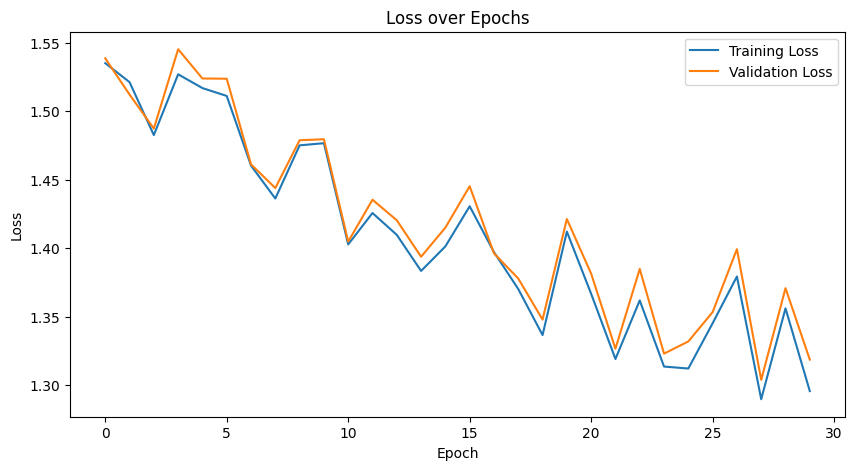

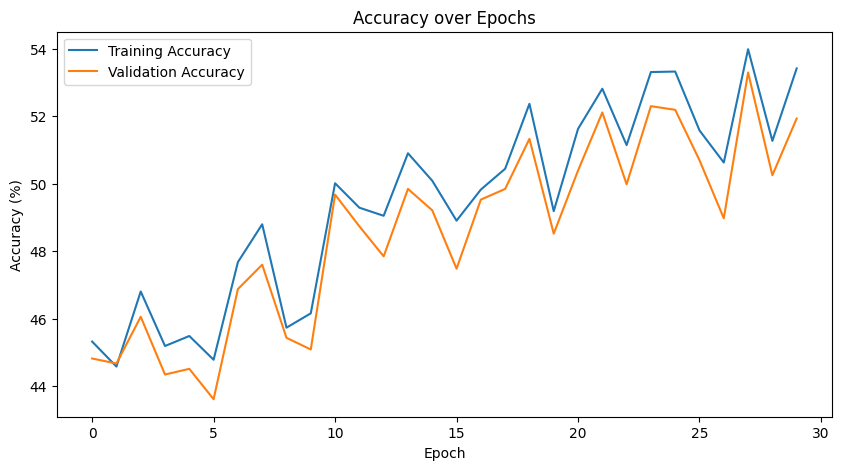

In [18]:
class ModifiedClassifier(nn.Module):

    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(ModifiedClassifier, self).__init__()

        # Patchify layer (modified kernel size)
        self.stem = nn.Conv2d(
            in_channels=3,
            out_channels=n_initial_filters,
            kernel_size=3,  # Larger kernel size
            stride=2       # Larger stride for coarser patches
        )

        current_shape = [16, 16]  # Reduced resolution due to patchify changes
        self.norm1 = nn.LayerNorm([n_initial_filters, *current_shape])

        current_n_filters = n_initial_filters
        self.layers = nn.Sequential()

        for i, n_blocks in enumerate(range(n_stages)):
            for _ in range(3):  # Increased convolutions per stage
                self.layers.append(
                    ConvNextBlock(in_channels=current_n_filters, shape=current_shape)
                )
            if i != n_stages - 1:
                self.layers.append(
                    Downsampler(
                        in_channels=current_n_filters,
                        out_channels=2 * current_n_filters,
                        shape=current_shape,
                    )
                )
                current_n_filters *= 2
                current_shape = [cs // 2 for cs in current_shape]

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )

    def forward(self, inputs):
        x = self.stem(inputs)
        x = self.norm1(x)
        x = self.layers(x)
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)
        return x

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        training_loss.append(loss)
        training_accuracy.append(acc)

    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        validation_loss.append(loss_val)
        validation_accuracy.append(acc_val)

    print(f"Epoch {j}: train loss: {loss:.3f}, acc: {acc:.3f} | val loss: {loss_val:.3f}, acc: {acc_val:.3f}")

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.show()

# Explanation of Changes
* Doubled the number of initial filters to 64 from 32. This should enable to network to capture more intricate features from the input images.
* Added an extra ConvNextBlock per stage to deepen the network. This should enable it to learn more complex patterns to reduce overfitting.
* Increased the kernel size. This should allow it to capture sptial relationships within a 3x3 neighborhood of pixels to promote better feature extraction.
* Added padding to ensure output dimensions match input dimensions.
* Increased the learning rate to speed up the optimizer convergence.
* Decrease the weight decay to lower regularization strength, balancing overfitting prevention without constraining learning capacity.
* Set manual seed for experiment reproducibility and consistent results.
* Separated the evaluation of training and validation sets for each epoch.
* Update the accuracy calculation to divide by total number of samples.